In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity, HeUniform
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np
import os
import random
%matplotlib inline

In [2]:
hyperparameters = {
    "learning_rate": 1E-4,
    "l2_regularization": 1E-6,
    "clip_value": 1,
    # "" ,
}

In [3]:
data_path = "../data/processed/small"
formatter = "data_{}.npz"
def get_num_files(path):
    return len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file)) and ".npz" in file and "data" in file]) 

# num_files = get_num_files(data_path) - 1
num_files = 2

In [4]:
l2 = tf.keras.regularizers.l2(l2=hyperparameters["l2_regularization"])

In [5]:
def identity_block(X, f, filters, momentum=0.99, training=True, initializer=HeUniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(), kernel_regularizer=l2)(X)
    X = BatchNormalization(axis = 3, momentum=momentum)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = f, strides = 1, padding = "same", kernel_initializer = initializer(), kernel_regularizer=l2)(X)
    X = BatchNormalization(axis = 3, momentum=momentum)(X, training = training)
    X = Activation('relu')(X) 

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(), kernel_regularizer=l2)(X)
    X = BatchNormalization(axis = 3, momentum=momentum)(X, training = training) 
    
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X) 

    return X

In [6]:
def convolutional_block(X, f, filters, momentum=0.99, s = 2, training=True, initializer=HeUniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(), kernel_regularizer=l2)(X)
    X = BatchNormalization(axis = 3, momentum=momentum)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding='same', kernel_initializer = initializer(), kernel_regularizer=l2)(X)
    X = BatchNormalization(axis = 3, momentum=momentum)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(), kernel_regularizer=l2)(X)
    X = BatchNormalization(axis = 3, momentum=momentum)(X, training=training)
    
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(), kernel_regularizer=l2)(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, momentum=momentum)(X_shortcut, training=training)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [7]:
def ChessNet(input_shape):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape)

    X = ZeroPadding2D((1, 1))(X_input)
    
    X = Conv2D(64, (3, 3), strides = (1, 1), kernel_initializer = HeUniform(), kernel_regularizer=l2)(X)
    X = BatchNormalization(axis = 3, momentum=0.99)(X, training=True)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(1, 1))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2) 
    X = identity_block(X, 3, [128,128,512]) 
    X = identity_block(X, 3, [128,128,512]) 
    X = identity_block(X, 3, [128,128,512]) 

    # X = ZeroPadding2D((3, 3))(X)
    
    # X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2) 
    # X = identity_block(X, 3, [256, 256, 1024]) 
    # X = identity_block(X, 3, [256, 256, 1024])  
    # X = identity_block(X, 3, [256, 256, 1024])  
    # X = identity_block(X, 3, [256, 256, 1024])  
    # X = identity_block(X, 3, [256, 256, 1024])  

    # X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2) 
    # X = identity_block(X, 3, [512, 512, 2048]) 
    # X = identity_block(X, 3, [512, 512, 2048])  

    X = AveragePooling2D(2)(X) 
    

    X = Flatten()(X)
    X = Dense(1, activation='tanh', kernel_initializer = glorot_uniform())(X)
    
    
    model = Model(inputs = X_input, outputs = X)

    return model

In [8]:
inp_shape_transpose = (8, 8, 13) 

model = ChessNet(inp_shape_transpose)

model.summary()

2021-08-13 16:34:00.976398: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 8, 13)]   0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 10, 10, 13)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 64)     7552        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8, 8, 64)     256         conv2d[0][0]                     
______________________________________________________________________________________________

In [9]:
adam = tf.keras.optimizers.Adam(learning_rate=hyperparameters["learning_rate"], clipvalue=hyperparameters["clip_value"])
model.compile(optimizer=adam, loss='mae', metrics=["mse"])
model.load_weights("../models/checkpoint_v2")

In [250]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss':[],'val_loss':[]}

    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.history['val_loss'].append(logs.get('val_loss'))

history = LossHistory()

In [12]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, path, num_files, batch_size=32, start_file=1, end_file=-1):
        self.path = path
        self.num_files = num_files
        if end_file == -1:
            self.end_file = self.num_files
        else:
            self.end_file = end_file
        self.file_order = [formatter.format(x) for x in range(start_file, self.end_file)]
        self.shuffle()
        self.calculate_len()
        self.batch_size = batch_size

    def calculate_len(self):
        self.dp_per_file = np.load(os.path.join(self.path, formatter.format(0)))["Y"].shape[0]
        self.length = len(self.file_order) * self.dp_per_file

    def shuffle(self):
        random.shuffle(self.file_order)

    def __len__(self):
        return self.length // self.batch_size

    def __getitem__(self, idx):
        file_index = idx * self.batch_size // self.dp_per_file
        file = np.load(os.path.join(self.path, self.file_order[file_index]))
        # handle between files case
        start_index = idx * self.batch_size % self.dp_per_file
        end_index = ((idx + 1) * self.batch_size - 1) % self.dp_per_file
        end_index += 1

        if end_index < start_index:
            # between files
            file_2 = np.load(os.path.join(self.path, self.file_order[file_index + 1]))
            x_batch = np.concatenate(file["X"][start_index:], file_2["X"][:end_index])
            y_batch = np.concatenate(file["Y"][start_index:], file_2["Y"][:end_index])
        else:
            x_batch = file["X"][start_index:end_index]
            y_batch = file["Y"][start_index:end_index]

        x_batch = tf.transpose(x_batch, [0, 2, 3, 1])
        # if tf.math.is_inf(x_batch).any():
        #     raise ValueError("X Batch {} contains inf or nan".format(idx))

        
        tf.debugging.check_numerics(y_batch, message='Checking y_batch')

        
        return x_batch, y_batch
        

train = Dataset(data_path, num_files)
test = Dataset(data_path, num_files, start_file=0, end_file=1)

In [252]:
model.fit(train, epochs=1, verbose=1, steps_per_epoch=len(train), validation_data=test, validation_steps=len(test)/1000, callbacks=[history])

13188/13188 [==============================] - 8268s 627ms/step - loss: 0.1762 - mse: 0.0775 - val_loss: 0.1186 - val_mse: 0.0521


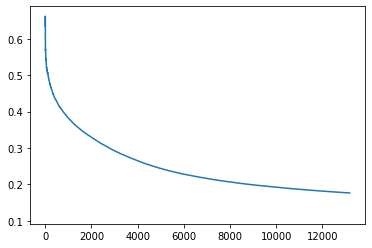

In [253]:
y1 = history.history['loss']
y2 = history.history['val_loss']
x1 = np.arange(len(y1))
fig, ax = plt.subplots()
line1, = ax.plot(x1, y1, label='loss')
if len(y2) != 0:
    k = len(y1)/len(y2)
    x2 = np.arange(k,len(y1)+1,k)
    line2, = ax.plot(x2, y2, label='val_loss')
plt.show()

In [13]:
# Parse Dataset (PGN) to Input Matrix
inp_shape = (13, 8, 8) 

# the first index is determined by piece type
king = 0
queen = 1
rook = 2
bishop = 3
knight = 4
pawn = 5

san_translate = {
    "p": pawn,
    "n": knight,
    "b": bishop,
    "r": rook, 
    "q": queen,
    "k": king
}

# structure of matrix:
#    - White is on top (0 - 5)
#    - Black is mirrored (6 - 11)
#    - Next move is 12 (0 - black, 1 - white)

def ajust_color(index, is_white):
    if is_white:
        return index
    else:
        return inp_shape[0] - index - 1

def get_index(san):
    is_white = san.isupper()
    index = san_translate[san.lower()]
    return ajust_color(index, is_white)


def fen_to_tensor(fen, move):
    ret = np.zeros(inp_shape)
    y = 0
    for rank in fen.split("/"):
        x = 0
        for char in rank:
            if char.isnumeric():
                x += int(char)
            else:
                ret[get_index(char)][y][x] = 1
                x += 1
        y += 1
    
    ret[-1] = move
    return tf.constant(ret, dtype=tf.int8)

In [14]:
# tensor = fen_to_tensor("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR", 1)
# tensor = tf.expand_dims(tensor, 0)
# tensor = tf.transpose(tensor, [0, 2, 3, 1])
# print(tensor)
tensor, gt = train[0]
out = model.predict(tensor)
model.evaluate(tensor, gt)
# out = model(tensor, False)
print(out)
print(gt)

2021-08-11 12:52:47.805172: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


1/1 [==============================] - 1s 1s/step - loss: 0.2377 - mse: 0.1472
[[-5.36096748e-04]
 [ 1.56173091e-02]
 [-1.85744010e-03]
 [ 1.58669113e-03]
 [-6.02811798e-02]
 [-2.60238826e-01]
 [-6.63632527e-03]
 [-1.21472485e-03]
 [ 7.79884111e-04]
 [-4.70033986e-03]
 [ 2.87526976e-02]
 [ 1.53373275e-03]
 [-2.73896032e-04]
 [-2.28462461e-03]
 [ 1.71093689e-03]
 [ 3.46469246e-02]
 [ 1.38308387e-02]
 [-2.19936064e-03]
 [ 8.31059879e-05]
 [ 2.05559959e-03]
 [-8.08556378e-03]
 [-3.35240318e-03]
 [-8.04168521e-04]
 [-1.62926316e-02]
 [-1.22190109e-02]
 [-5.62177366e-03]
 [ 2.68239826e-02]
 [ 6.16472773e-03]
 [-1.00166835e-02]
 [ 3.88564891e-04]
 [ 1.35055542e-01]
 [ 7.43439747e-03]]
[ 7.6562500e-01  1.2197358e-02 -2.0808153e-02  6.6992188e-01
 -3.5497792e-02 -4.4879532e-01 -4.4879532e-01 -6.6992188e-01
  1.0000000e+00  3.7885684e-04  7.6562500e-01  1.8747102e-07
 -3.7885684e-04  1.1025815e-03  3.0065781e-01  6.6992188e-01
  2.1496634e-03 -2.7177997e-02 -6.0156202e-10  2.3019113e-01
 -2.900

In [259]:
model.save("model_large_data")

2021-08-09 21:12:47.722645: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/Users/danielkopp/Documents/projects/2021/new_chess/chess_env/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: init_model/assets
